### Import Packages

In [1]:
import pandas as pd
import numpy as np
import os
from PIL import Image
from tqdm import tqdm
import torch
from transformers import ViTImageProcessor, ViTForImageClassification, ViTFeatureExtractor, ViTConfig, TrainingArguments, Trainer
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from torch.nn import BCEWithLogitsLoss
from datasets import Dataset, DatasetDict, concatenate_datasets

### Image and Labels Loading and Matching

In [2]:
# Load the Data from CSV
csv_file = "clean_MovieGenre.csv"  # Path to your CSV file
df = pd.read_csv(csv_file)

# Specify the binarized columns
binarized_columns = ['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 
                     'Drama', 'Family', 'Fantasy', 'Film-Noir', 'History', 'Horror', 'Music', 'Musical', 
                     'Mystery', 'Romance', 'Sci-Fi', 'Short', 'Sport', 'Thriller', 'War', 'Western']

In [3]:
class ImageDataset(Dataset):
    def __init__(self, images, labels, processor):
        self.images = images
        self.labels = labels.astype(np.float32)
        self.processor = processor  # Store the processor as an attribute

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        # Process image using the provided processor
        inputs = self.processor(images=image, return_tensors="pt")
        processed_image = inputs.pixel_values.squeeze(0)  # Remove batch dimension

        return {"pixel_values": processed_image, "labels": label}


In [4]:
image_folder = "downloaded_images" #sample_images for developing, downloaded_images for final
images = []
labels = []
batch_size = 128  

# Load images and labels in batches
num_batches = len(df) // batch_size + 1

for batch_num in tqdm(range(num_batches)):
    start_idx = batch_num * batch_size
    end_idx = min((batch_num + 1) * batch_size, len(df))
    
    batch_df = df.iloc[start_idx:end_idx]
    batch_images = []
    batch_labels = []
    
    for index, row in batch_df.iterrows():
        filename = str(row.iloc[0]) + ".jpg"  # filenames match the imdbIDs
        label = [int(row[column]) for column in binarized_columns]  # Extract binarized labels for each genre

        image_path = os.path.join(image_folder, filename)
        try:
            image = Image.open(image_path)  # Open image using PIL
            image = image.convert("RGB")  # Convert image to RGB mode if necessary
            image_array = np.array(image)  # Convert PIL Image to numpy array
            batch_images.append(image_array)
            batch_labels.append(label)
        except Exception as e:
            pass
    # Concatenate the batches of images and labels
    if batch_images:
        images.append(np.array(batch_images))
        labels.append(np.array(batch_labels))

# Concatenate all batches into single numpy arrays
if images:
    images = np.concatenate(images, axis=0)
    labels = np.concatenate(labels, axis=0)

100%|██████████| 260/260 [00:35<00:00,  7.26it/s]


### Sample Posters

Images shape: (33275, 268, 182, 3)
Labels shape: (33275, 23)


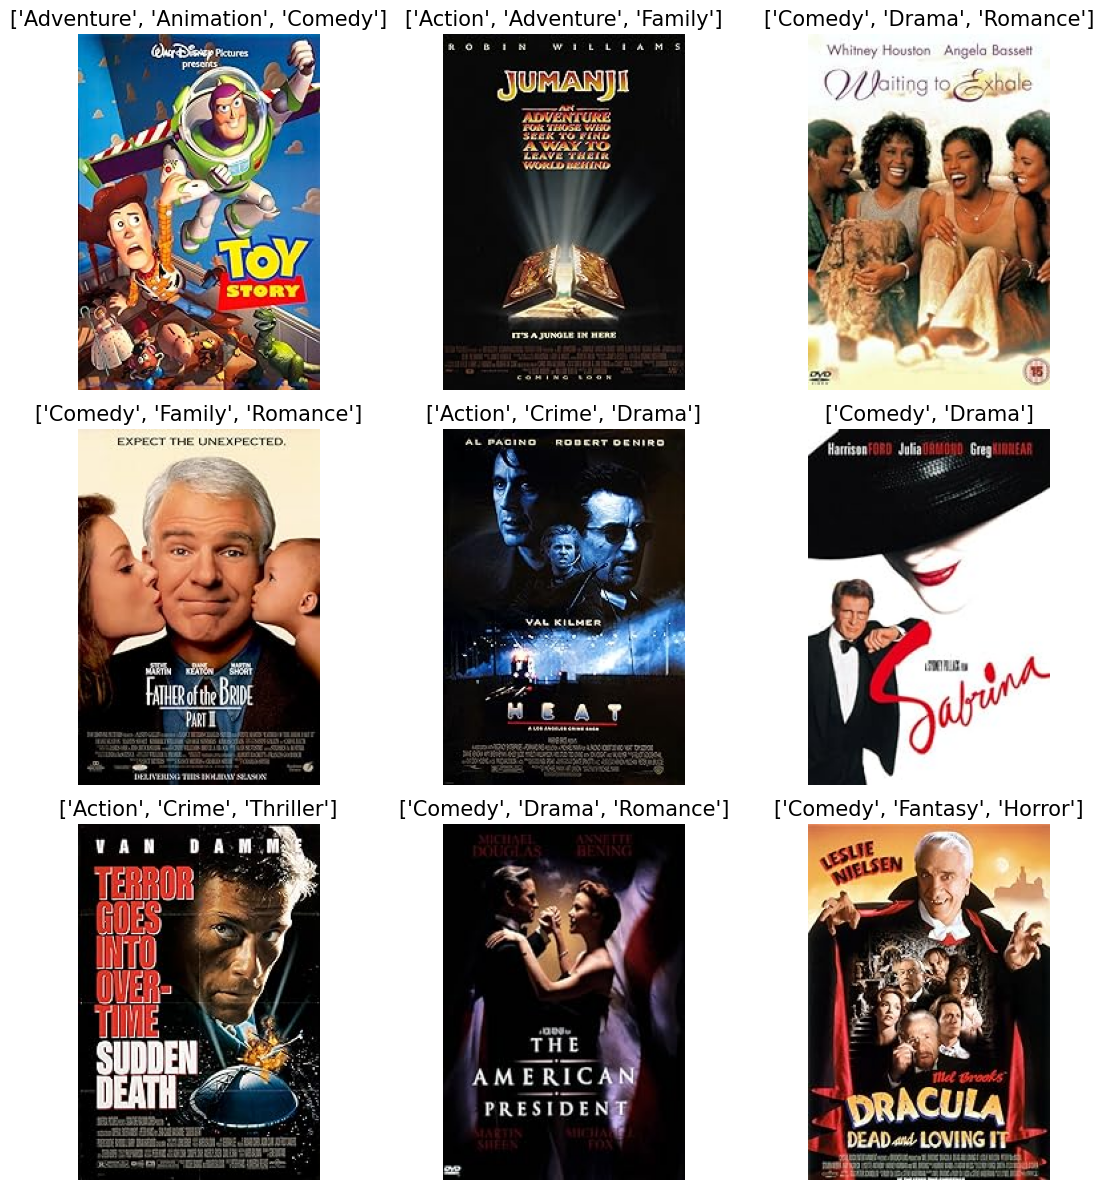

In [5]:
# Print the shapes of the loaded data
print("Images shape:", images.shape)
print("Labels shape:", labels.shape)

# Display sample images
plt.figure(figsize=(12, 12))
for i in range(9):
	ax = plt.subplot(3, 3, i + 1)
	plt.imshow(images[i])
	plt.axis('off')
	plt.title([column for column, label in zip(binarized_columns, labels[i]) if label == 1], fontsize=15)
plt.tight_layout()
plt.show()

### Preprocessing

In [6]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# Print the shapes of the split datasets
print("Training images shape:", X_train.shape)
print("Training labels shape:", y_train.shape)

print("Validation images shape:", X_val.shape)
print("Validation labels shape:", y_val.shape)

print("Testing images shape:", X_test.shape)
print("Testing labels shape:", y_test.shape)

Training images shape: (26620, 268, 182, 3)
Training labels shape: (26620, 23)
Validation images shape: (3328, 268, 182, 3)
Validation labels shape: (3328, 23)
Testing images shape: (3327, 268, 182, 3)
Testing labels shape: (3327, 23)


In [7]:
#Display Distribution
train_label_distribution = np.sum(y_train, axis=0)
val_label_distribution = np.sum(y_val, axis=0)
test_label_distribution = np.sum(y_test, axis=0)

combined_data = {
    "Label": binarized_columns,
    "Train Distribution": train_label_distribution,
    "Validation Distribution": val_label_distribution,
    "Test Distribution": test_label_distribution
}

df = pd.DataFrame(combined_data)
print(df)

          Label  Train Distribution  Validation Distribution  \
0        Action                3608                      431   
1     Adventure                2567                      308   
2     Animation                1189                      125   
3     Biography                1325                      192   
4        Comedy                8517                     1071   
5         Crime                3496                      407   
6   Documentary                2629                      361   
7         Drama               13432                     1641   
8        Family                1417                      166   
9       Fantasy                1365                      168   
10    Film-Noir                 211                       31   
11      History                 971                      136   
12       Horror                2646                      340   
13        Music                 858                       99   
14      Musical                 543     

In [8]:
# Ensure pixel values are in the range of 0 to 255 and are float32
X_train = np.clip(X_train, 0, 255)
X_val = np.clip(X_val, 0, 255)
X_test = np.clip(X_test, 0, 255)

X_train = X_train.astype(np.float32)
X_val = X_val.astype(np.float32)
X_test = X_test.astype(np.float32)

X_train = np.transpose(X_train, (0, 3, 1, 2))
X_val = np.transpose(X_val, (0, 3, 1, 2))
X_test = np.transpose(X_test, (0, 3, 1, 2))

# Ensure labels are int64
y_train = y_train.astype(np.int64)
y_val = y_val.astype(np.int64)
y_test = y_test.astype(np.int64)

In [ ]:
class LazyLoadDataset(Dataset):
    def __init__(self, data_paths, labels, transform=None):
        self.data_paths = data_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data_paths)

    def __getitem__(self, index):
        # Load data from disk or source when requested
        data = load_data(self.data_paths[index])  # Implement load_data function
        label = self.labels[index]
        if self.transform:
            data = self.transform(data)
        return {"pixel_values": data, "labels": label}

In [ ]:

def shard_dataset(X, y, shard_size=10000):
    for i in range(0, len(X), shard_size):
        yield X[i:i + shard_size], y[i:i + shard_size]

In [ ]:

train_shards = list(shard_dataset(X_train, y_train))
val_shards = list(shard_dataset(X_val, y_val))
test_shards = list(shard_dataset(X_test, y_test))

In [ ]:

# # Process shards as needed
# train_datasets = [Dataset.from_dict(shard) for shard in train_shards]
# val_datasets = [Dataset.from_dict(shard) for shard in val_shards]
# test_datasets = [Dataset.from_dict(shard) for shard in test_shards]

In [ ]:
# Create lazy loading datasets
train_datasets = [LazyLoadDataset(data_paths=shard[0], labels=shard[1]) for shard in train_shards]
val_datasets = [LazyLoadDataset(data_paths=shard[0], labels=shard[1]) for shard in val_shards]
test_datasets = [LazyLoadDataset(data_paths=shard[0], labels=shard[1]) for shard in test_shards]

In [11]:
train_dataset = concatenate_datasets(train_datasets)
val_dataset = concatenate_datasets(val_datasets)
test_dataset = concatenate_datasets(test_datasets)

### Modeling

In [12]:
# Load the default ViT model configuration
vit_config = ViTConfig.from_pretrained('google/vit-base-patch16-224-in21k')

# Update the image size in the configuration
vit_config = ViTConfig(
    image_size=(268, 182),
    problem_type="multi_label_classification",
	num_labels=len(binarized_columns),
    is_classifier=True,
    classifier_activation="sigmoid"
)

c:\Python312\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [13]:
# Model Specification
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k', config=vit_config, ignore_mismatched_sizes=True)

#utilize cuda if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)
model = model.to(device)

# # Utilize MPS backend if available (specific to Apple Silicon)
# device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
# print("Using device:", device)
# model = model.to(device)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized because the shapes did not match:
- embeddings.position_embeddings: found shape torch.Size([1, 197, 768]) in the checkpoint and torch.Size([1, 177, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cuda


### Training

In [19]:
training_args = TrainingArguments(
    output_dir='output',
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=16,   
    num_train_epochs=1,             
    logging_dir='./logs',
    logging_steps=50,               
    save_steps=200,                 
    evaluation_strategy="epoch",    
    fp16=True,                      
    # gradient_accumulation_steps=2,  
    # dataloader_num_workers=4,       
    learning_rate=2e-5,            
    weight_decay=0.01,             
    save_total_limit=2,            
)

In [21]:
def compute_metrics(pred):
    logits = pred.predictions
    labels = pred.label_ids
    
    # Apply sigmoid to get probabilities
    probabilities = torch.sigmoid(torch.tensor(logits)).numpy()
    
    # Define a threshold to get binary predictions
    threshold = 0.5
    predictions = (probabilities > threshold).astype(int)
    
    f1 = f1_score(labels, predictions, average='micro')
    
    return {
        'f1_score': f1,
    }

In [22]:
# Custom Trainer
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels").float()  # Ensure labels are float
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = BCEWithLogitsLoss()
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

In [23]:
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

In [24]:
trainer.train()

  0%|          | 0/1664 [00:00<?, ?it/s]

c:\Python312\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


{'loss': 0.5492, 'grad_norm': 0.34459343552589417, 'learning_rate': 1.9399038461538464e-05, 'epoch': 0.03}
{'loss': 0.4361, 'grad_norm': 0.310423344373703, 'learning_rate': 1.8798076923076926e-05, 'epoch': 0.06}
{'loss': 0.4074, 'grad_norm': 0.2556641101837158, 'learning_rate': 1.8197115384615388e-05, 'epoch': 0.09}
{'loss': 0.3829, 'grad_norm': 0.257107675075531, 'learning_rate': 1.7596153846153846e-05, 'epoch': 0.12}
{'loss': 0.3624, 'grad_norm': 0.22023989260196686, 'learning_rate': 1.699519230769231e-05, 'epoch': 0.15}
{'loss': 0.3458, 'grad_norm': 0.20930059254169464, 'learning_rate': 1.639423076923077e-05, 'epoch': 0.18}


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x0000025E5E2AC320>>
Traceback (most recent call last):
  File "c:\Python312\Lib\site-packages\ipykernel\ipkernel.py", line 790, in _clean_thread_parent_frames
    active_threads = {thread.ident for thread in threading.enumerate()}
                                                 ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python312\Lib\threading.py", line 1533, in enumerate
    def enumerate():
    
KeyboardInterrupt: 


{'loss': 0.332, 'grad_norm': 0.18037289381027222, 'learning_rate': 1.5793269230769233e-05, 'epoch': 0.21}
{'loss': 0.3235, 'grad_norm': 0.19204261898994446, 'learning_rate': 1.5192307692307693e-05, 'epoch': 0.24}
{'loss': 0.3054, 'grad_norm': 0.157368004322052, 'learning_rate': 1.4591346153846155e-05, 'epoch': 0.27}
{'loss': 0.3051, 'grad_norm': 0.14224810898303986, 'learning_rate': 1.3990384615384615e-05, 'epoch': 0.3}
{'loss': 0.2953, 'grad_norm': 0.13588044047355652, 'learning_rate': 1.3389423076923077e-05, 'epoch': 0.33}
{'loss': 0.2886, 'grad_norm': 0.11710435152053833, 'learning_rate': 1.2788461538461538e-05, 'epoch': 0.36}
{'loss': 0.2872, 'grad_norm': 0.12722279131412506, 'learning_rate': 1.2187500000000001e-05, 'epoch': 0.39}
{'loss': 0.2856, 'grad_norm': 0.14748790860176086, 'learning_rate': 1.1586538461538464e-05, 'epoch': 0.42}
{'loss': 0.2802, 'grad_norm': 0.10776844620704651, 'learning_rate': 1.0985576923076924e-05, 'epoch': 0.45}
{'loss': 0.2806, 'grad_norm': 0.095966622

c:\Python312\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


  0%|          | 0/208 [00:00<?, ?it/s]

{'eval_loss': 0.262103796005249, 'eval_f1_score': 0.2244989867147039, 'eval_runtime': 239.6423, 'eval_samples_per_second': 13.887, 'eval_steps_per_second': 0.868, 'epoch': 1.0}
{'train_runtime': 2539.7238, 'train_samples_per_second': 10.481, 'train_steps_per_second': 0.655, 'train_loss': 0.3028947569143314, 'epoch': 1.0}


TrainOutput(global_step=1664, training_loss=0.3028947569143314, metrics={'train_runtime': 2539.7238, 'train_samples_per_second': 10.481, 'train_steps_per_second': 0.655, 'total_flos': 2.0052983743205212e+18, 'train_loss': 0.3028947569143314, 'epoch': 1.0})

### Testing

In [34]:
# Ensure processor has the correct image size
processor.size = (268, 182)  # Set the processor size to match the model

# Perform inference
model.eval()
predicted_probabilities = []

for i in range(0, len(X_test), batch_size):
    # Process batch inputs
    batch_images = X_test[i:i+batch_size]
    processed_images = []
    for img in batch_images:
        # Convert float32 to uint8 and transpose if necessary
        img_uint8 = (img * 255).astype(np.uint8)
        img_rgb = np.transpose(img_uint8, (1, 2, 0))  # Transpose to (height, width, channels)
        processed_images.append(img_rgb)
    
    # Convert numpy arrays to lists of PIL images and process
    batch_inputs = processor(images=[Image.fromarray(img) for img in processed_images], return_tensors="pt") 
    batch_inputs = {k: v.to(device) for k, v in batch_inputs.items()}
    
    with torch.no_grad():
        # Forward pass
        outputs = model(**batch_inputs)
    
    # Get the predicted logits
    logits = outputs.logits
    
    # Convert logits to probabilities using sigmoid
    probabilities = torch.sigmoid(logits)
    
    # Append predicted probabilities for this batch
    predicted_probabilities.append(probabilities.cpu().numpy())

# Concatenate predicted probabilities for all batches
predicted_probabilities = np.concatenate(predicted_probabilities, axis=0)


In [35]:
# Convert lists to NumPy arrays
y_test_np = np.array(y_test)
predicted_probabilities_np = np.array(predicted_probabilities)

# Ensure that the arrays have the appropriate shape
y_test_np = np.vstack([np.array(y) for y in y_test_np])

# Define the threshold for binary classification
threshold = 0.5

# Threshold predicted probabilities to obtain binary predictions
predicted_labels_np = (predicted_probabilities_np > threshold).astype(int)

### Evaluation

In [36]:
# Initialize lists to store F1 scores and accuracies for each label
f1_scores = []
accuracies = []
predicted_binary_labels = (predicted_probabilities > threshold).astype(int)

# Iterate over each label
for i, label in enumerate(binarized_columns):
    # Calculate F1 score
    f1 = f1_score(y_test_np[:, i], predicted_labels_np[:, i], average='binary')
    f1_scores.append(f1)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test[:, i], predicted_binary_labels[:, i])
    accuracies.append(accuracy)

data = {
    "Label": binarized_columns,
    "F1 Score": f1_scores,
    "Accuracy": accuracies
}

df = pd.DataFrame(data)
print(df)

# Compute average F1 score
avg_f1_score = np.mean(f1_scores)
print("\nAverage F1 score:", avg_f1_score)

# Compute average accuracy
average_accuracy = sum(accuracies) / len(accuracies)
print("Average accuracy:", average_accuracy)

          Label  F1 Score  Accuracy
0        Action  0.000000  0.865044
1     Adventure  0.000000  0.906823
2     Animation  0.000000  0.957018
3     Biography  0.000000  0.949504
4        Comedy  0.000000  0.687707
5         Crime  0.000000  0.874962
6   Documentary  0.000000  0.922453
7         Drama  0.424803  0.495341
8        Family  0.000000  0.946198
9       Fantasy  0.000000  0.951608
10    Film-Noir  0.000000  0.991885
11      History  0.000000  0.968440
12       Horror  0.000000  0.887286
13        Music  0.000000  0.969943
14      Musical  0.000000  0.981365
15      Mystery  0.000000  0.935377
16      Romance  0.000000  0.849714
17       Sci-Fi  0.000000  0.950406
18        Short  0.000000  0.977157
19        Sport  0.000000  0.982867
20     Thriller  0.000000  0.876165
21          War  0.000000  0.969041
22      Western  0.000000  0.980763

Average F1 score: 0.018469696292655317
Average accuracy: 0.9076985402699912


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


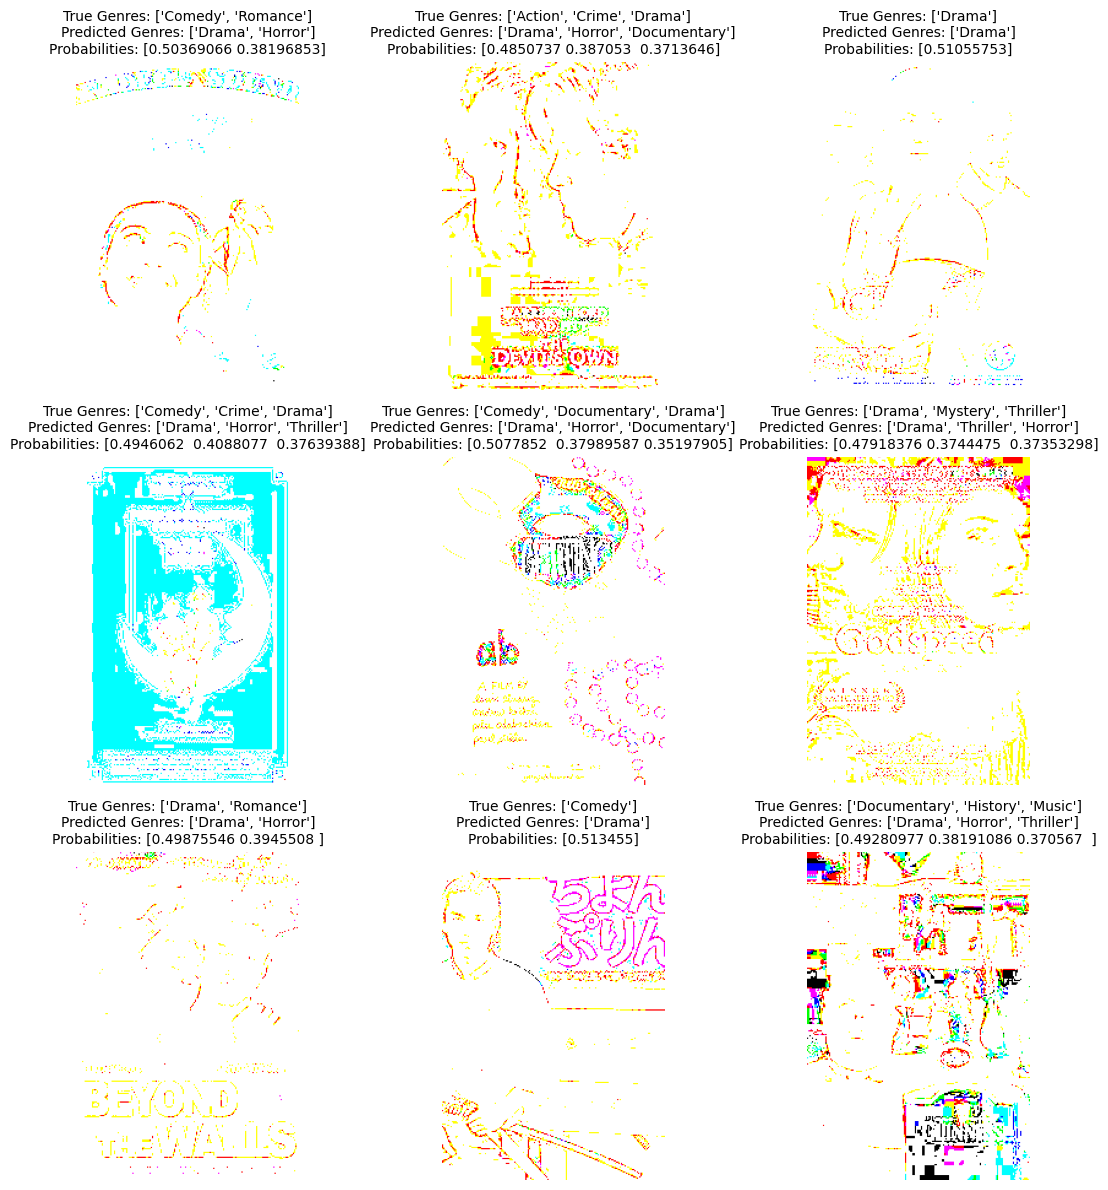

In [37]:
def display(X_test, y_test, predicted_probabilities, binarized_columns, threshold=0.5):
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))

    for idx, ax in enumerate(axes.flat):
        if idx < len(X_test):
            poster = X_test[idx].transpose(1, 2, 0)  # Transpose back to (height, width, channels)
            true_labels = [binarized_columns[i] for i, label in enumerate(y_test[idx]) if label == 1]
            predicted_genre_probabilities = predicted_probabilities[idx]

            # Sort predicted probabilities and select labels based on the number of true labels
            num_true_labels = len(true_labels)
            top_predicted_idx = np.argsort(predicted_genre_probabilities)[::-1][:num_true_labels]
            predicted_genre_labels = [binarized_columns[i] for i in top_predicted_idx]
            top_predicted_probabilities = predicted_genre_probabilities[top_predicted_idx]

            ax.imshow(poster)
            ax.set_title(f"True Genres: {true_labels}\nPredicted Genres: {predicted_genre_labels}\nProbabilities: {top_predicted_probabilities}", fontsize=10)
            ax.axis('off')
        else:
            ax.axis('off')  # Hide empty subplots
        
    plt.tight_layout()
    plt.show()

display(X_test, y_test, predicted_probabilities, binarized_columns)
